# Hamming weight and Pearson Correlation

This notebook demonstrates how to guess a floating number using Hamming Weight model.


We generate a random secret floating number. Then we use hamming weight model to guess the number.

We develop a method of devide-and-conquer to quickly arrive to a close number with a defined precision.

## Guessing...

In [1]:
import struct
import numpy as np
import pandas as pd
import random
from pprint import pprint
import hashlib
import binascii
from guess_range import *

In [2]:
def generate_known_inputs(exps=(-1, 3), nsize=3000):
    low, high = exps[0], (exps[1] + 1)
    subsize = int(nsize / (high - low))
    return pd.DataFrame(
        data=[np.random.uniform(-10.0 ** i, 10.0 ** i, subsize) for i in range(low, high)],
        index=range(low, high))

def secret_signature(secret_numbers):
    m = hashlib.md5()
    m.update(secret_numbers)
    a = m.digest()
    s = 2
    n = [0] * s
    for idx in range(len(a)):
        i = idx % s
        n[i] = (n[i] + a[idx]) % 256
    return binascii.hexlify(bytes(n))        

In [3]:
def guess_number_range_stat(secret_number, guess_range, prescision, known_input_size=3000):
    known_input_set = generate_known_inputs(exps=(-1, 8), nsize=known_input_size)
    results = guess_number_range_multiple_inputs(secret_number, guess_range, prescision, known_input_set)
    # pprint(results)
    #
    # discard low correlation results
    corr_values = results[CORRELATION]
    results = results[corr_values > (corr_values.max() * 0.95)].sort_values(CORRELATION, ascending=False)
    guess_values = ((results[LOW_VALUE] + results[HIGH_VALUE]) / 2.0).round(decimals=int(-np.log10(prescision)))
    return results[~guess_values.duplicated(keep='first')]

In [52]:
SECRET_VALUE = 'secret value'

guess_range = (-5e0, 5.0e0)
prescision = 1e-8
#
# initalize parameter and generate a random number (secret number)
known_input_size = 5000

## Test single point

In [5]:
secret_number = random.uniform(guess_range[0] / 10, guess_range[1] / 10) 
secret_number = -0.001374

In [6]:
%%time
single_results = guess_number_range_stat(secret_number, guess_range, prescision, known_input_size)
print(secret_number)
single_results

-0.001374
CPU times: user 49.7 s, sys: 1.29 s, total: 50.9 s
Wall time: 50.9 s


,low value,high value,correlation
0,-1.406976,-1.406976,0.976540
2,-2.813952,-2.813952,0.944013


In [7]:
guess_values = (single_results[LOW_VALUE] + single_results[HIGH_VALUE]) / 2.0
error_rates = ((guess_values - secret_number) / secret_number).abs() * 100.0
pprint(error_rates)
guessed_number = guess_values[error_rates.idxmin()]    
pprint('the secret number = %f' % secret_number)
pprint('the guessed number = %f' % guessed_number)
pprint('best correlation = %f' % single_results[CORRELATION][error_rates.idxmin()])
pprint('error rate = %0.6f%s' % (error_rates.min(), '%'))

0    102299.999894
2    204700.000127
dtype: float64
'the secret number = -0.001374'
'the guessed number = -1.406976'
'best correlation = 0.976540'
'error rate = 102299.999894%'


## Test multiple points

In [8]:
multiple_results = pd.DataFrame()

In [9]:
n_secret_numbers = 100
secret_numbers = np.concatenate((
    np.random.uniform(guess_range[0], guess_range[1], int(n_secret_numbers*2/4) ),
    np.random.uniform(guess_range[0]*3e-1, guess_range[1]*3e-1, int(n_secret_numbers*1/4)),
    np.random.uniform(guess_range[0]*1e-1, guess_range[1]*1e-1, int(n_secret_numbers*1/4))
))
np.random.shuffle(secret_numbers)
print('secret_numbers.shape = %s' % (str(secret_numbers.shape)))

secret_numbers.shape = (100,)


In [10]:
%%time
loops = 0
for idx in secret_numbers:
    # if the number is already treated, the ignore it
    if (SECRET_VALUE in multiple_results.columns) and (idx in multiple_results[SECRET_VALUE].values):
        continue    
    results = guess_number_range_stat(idx, guess_range, prescision, known_input_size)
    results[SECRET_VALUE] = idx
    pprint('=' * 20)
    pprint(results)
    guess_values = (results[LOW_VALUE] + results[HIGH_VALUE]) / 2.0
    multiple_results = pd.concat([multiple_results, results], axis=0, ignore_index=True)
    loops = loops + 1

'===================='
   low value  high value  correlation  secret value
2   0.116897    0.116897     0.999754      0.116897
8   1.870357    1.870357     0.986933      0.116897
'===================='
    low value  high value  correlation  secret value
-1  -1.225407   -1.225407          1.0     -1.225407
'===================='
   low value  high value  correlation  secret value
1  -0.460877   -0.460877     1.000000     -0.460877
0  -1.843506   -1.843506     0.983765     -0.460877
4  -3.687012   -3.687012     0.952335     -0.460877
'===================='
    low value  high value  correlation  secret value
 1   0.145472    0.145472     1.000000      0.145472
-1   2.327559    2.327559     0.982696      0.145472
 8   4.655118    4.655118     0.958856      0.145472
'===================='
    low value  high value  correlation  secret value
-1  -4.233629   -4.233629          1.0     -4.233629
'===================='
   low value  high value  correlation  secret value
0   2.617823    2.6178

'===================='
    low value  high value  correlation  secret value
-1  -1.236503   -1.236503          1.0     -1.236503
'===================='
    low value  high value  correlation  secret value
-1  -3.573372   -3.573372          1.0     -3.573372
'===================='
   low value  high value  correlation  secret value
1   0.372239    0.372239      1.00000      0.372239
0   1.488956    1.488956      0.98058      0.372239
'===================='
   low value  high value  correlation  secret value
1  -1.189267   -1.189267      1.00000     -1.189267
4  -4.757066   -4.757066      0.97523     -1.189267
'===================='
    low value  high value  correlation  secret value
-1   1.284135    1.284135          1.0      1.284135
'===================='
    low value  high value  correlation  secret value
-1  -2.748031   -2.748031     1.000000     -2.748031
 4  -0.171752   -0.171752     0.984502     -2.748031
'===================='
    low value  high value  correlation  secret val

'===================='
    low value  high value  correlation  secret value
-1  -1.334768   -1.334768          1.0     -1.334768
'===================='
    low value  high value  correlation  secret value
-1  -3.429919   -3.429919     0.998625     -0.013398
 3  -0.013398   -0.013398     0.998054     -0.013398
'===================='
   low value  high value  correlation  secret value
0  -0.730307   -0.730307     1.000000     -0.730307
7  -2.921229   -2.921229     0.979108     -0.730307
'===================='
    low value  high value  correlation  secret value
-1  -0.111789   -0.111789     1.000000     -0.111789
 0  -1.788630   -1.788630     0.994453     -0.111789
'===================='
   low value  high value  correlation  secret value
1  -4.576267   -4.576267          1.0     -4.576267
2  -4.576267   -4.576267          1.0     -4.576267
'===================='
    low value  high value  correlation  secret value
 1  -1.194383   -1.194383     1.000000     -1.194383
-1  -4.777534   -4.7

### Save data

In [11]:
from datetime import datetime
multiple_results_fname = 'multiple_results-%s_%s.csv' % (datetime.now().strftime("%Y%m%d"), secret_signature(secret_numbers).decode('utf8'))
multiple_results.to_csv(multiple_results_fname)
pprint('multiple_results_fname = %s' % multiple_results_fname)

'multiple_results_fname = multiple_results-20200524_cc0c.csv'


### Load data

In [12]:
# multiple_results_fname = 'multiple_results-20200523_011136.csv'
multiple_results = pd.read_csv(multiple_results_fname, index_col=0)
multiple_results

,low value,high value,correlation,secret value
0,0.116897,0.116897,0.999754,0.116897
1,1.870357,1.870357,0.986933,0.116897
2,-1.225407,-1.225407,1.000000,-1.225407
3,-0.460877,-0.460877,1.000000,-0.460877
4,-1.843506,-1.843506,0.983765,-0.460877
...,...,...,...,...
188,-4.576267,-4.576267,1.000000,-4.576267
189,-1.194383,-1.194383,1.000000,-1.194383
190,-4.777534,-4.777534,0.981075,-1.194383
191,-1.007541,-1.007541,1.000000,-1.007541


### Hit targets and missed targets

In [53]:
#
# compute the number of secret values which are present in guessed ranges
n_identified_ranges = multiple_results.groupby(SECRET_VALUE).apply(lambda x: ((x[LOW_VALUE]<=x[SECRET_VALUE]) & (x[SECRET_VALUE]<=x[HIGH_VALUE])).any())
counts = n_identified_ranges.value_counts()
if True in counts.index:
    pprint('The number of identified values: %d/%d' % (counts[True], counts.sum()))
if False in counts.index:
    pprint('The number of missed values: %d/%d' % (counts[False], counts.sum()))

'The number of identified values: 97/100'
'The number of missed values: 3/100'


In [14]:
df = multiple_results.loc[multiple_results.groupby(SECRET_VALUE)[CORRELATION].idxmax()]
df['guess_values'] = (df[LOW_VALUE] + df[HIGH_VALUE]) / 2.0
df['error_rate'] = ((df['guess_values'] - df[SECRET_VALUE])/df[SECRET_VALUE]).abs()
df.sort_values('error_rate')

,low value,high value,correlation,secret value,guess_values,error_rate
163,-4.763726,-4.763726,1.000000,-4.763726,-4.763726,6.592401e-11
142,-0.483626,-0.483626,1.000000,-0.483626,-0.483626,7.049916e-11
110,-2.508634,-2.508634,1.000000,-2.508634,-2.508634,7.118483e-11
55,-3.972196,-3.972196,1.000000,-3.972196,-3.972196,1.301764e-10
104,3.691907,3.691907,1.000000,3.691907,3.691907,1.330725e-10
...,...,...,...,...,...,...
60,0.036604,0.036604,1.000000,0.036604,0.036604,4.511488e-08
85,-0.071605,-0.071605,1.000000,-0.071605,-0.071605,5.191014e-08
75,-2.340698,-2.340698,0.930610,-2.340698,-2.340698,9.535532e-08
127,2.487528,2.487528,0.989138,0.155470,2.487528,1.500000e+01


### Graphs of the first choices

In [54]:
first_choice_results = multiple_results.loc[multiple_results.groupby(SECRET_VALUE)[CORRELATION].idxmax()]
guess_values = (first_choice_results[LOW_VALUE] + first_choice_results[HIGH_VALUE]) / 2.0
guess_values.index = first_choice_results[SECRET_VALUE]
guess_values.sort_index(inplace=True)
error_rate = ((guess_values - guess_values.index)/guess_values.index).abs()
(error_rate < prescision).value_counts()

True     86
False    14
dtype: int64

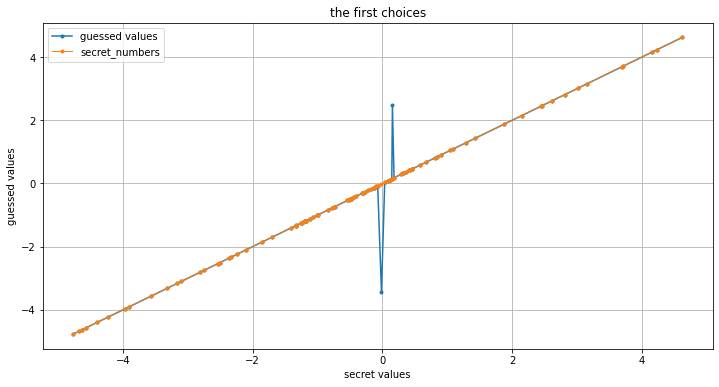

In [40]:
ax = guess_values.plot(figsize = (12, 6), marker='.', label='guessed values')
ax.plot(guess_values.index, guess_values.index, marker='.', linewidth=1, label='secret_numbers')
ax.legend()
ax.set_xlabel('secret values')
ax.set_ylabel('guessed values')
ax.set_title('the first choices')
ax.grid(True)

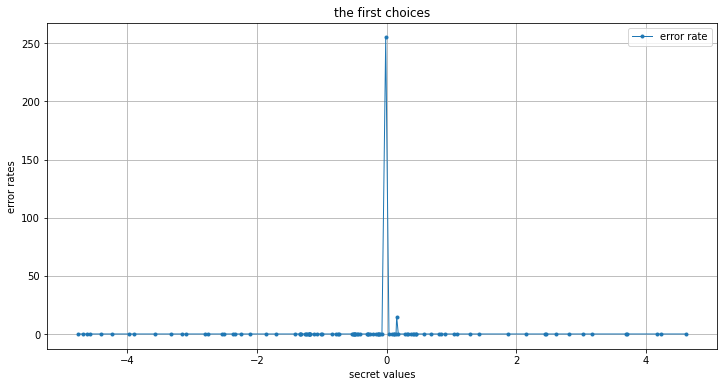

In [41]:
ax = error_rate.plot(figsize = (12, 6), label='error rate', marker='.', linewidth=1)
ax.legend()
ax.set_xlabel('secret values')
ax.set_ylabel('error rates')
ax.set_title('the first choices')
ax.grid(True)

### Graphs of the second choice

In [46]:
pprint('The total number of the second choices is: %d' % (multiple_results.groupby(SECRET_VALUE).size().prod()-1))

'The total number of the second choices is: 7945475642588397567'


In [47]:
guess_values = ((multiple_results[LOW_VALUE] + multiple_results[HIGH_VALUE]) / 2.0)
error_rate = ((guess_values - multiple_results[SECRET_VALUE])/multiple_results[SECRET_VALUE]).abs()
second_choice_results = multiple_results.loc[error_rate.groupby(multiple_results[SECRET_VALUE]).idxmin()]
guess_values = ((second_choice_results[LOW_VALUE] + second_choice_results[HIGH_VALUE]) / 2.0)
guess_values.index = second_choice_results[SECRET_VALUE]
guess_values.sort_index(inplace=True)

error_rate = ((guess_values - guess_values.index)/guess_values.index).abs()
(error_rate < prescision).value_counts()

True     99
False     1
dtype: int64

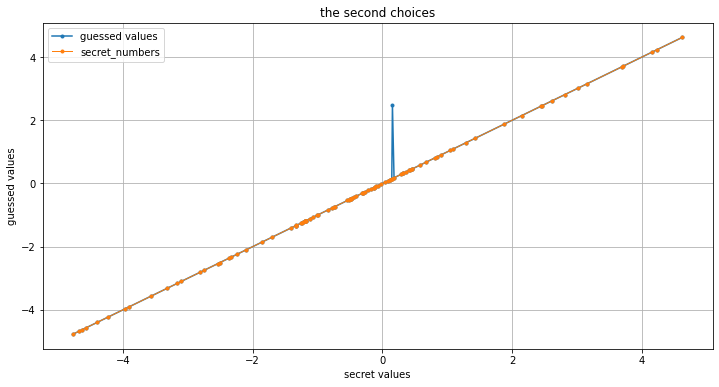

In [48]:
ax = guess_values.plot(figsize = (12, 6), marker='.', label='guessed values')
ax.plot(guess_values.index, guess_values.index, marker='.', linewidth=1, label='secret_numbers')
ax.legend()
ax.set_xlabel('secret values')
ax.set_ylabel('guessed values')
ax.set_title('the second choices')
ax.grid(True)

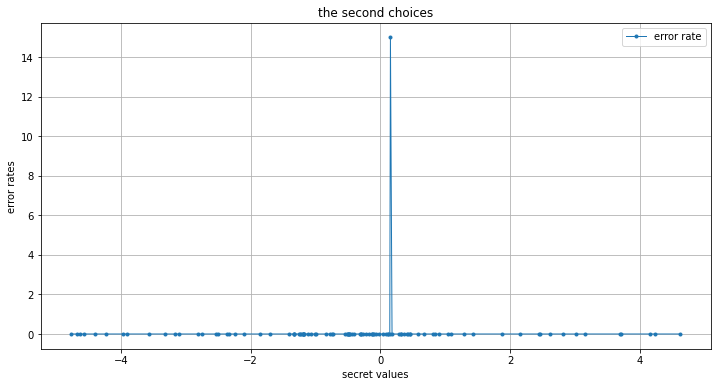

In [49]:
ax = error_rate.plot(figsize = (12, 6), label='error rate', marker='.', linewidth=1)
ax.legend()
ax.set_xlabel('secret values')
ax.set_ylabel('error rates')
ax.set_title('the second choices')
ax.grid(True)

# Batina method

In [22]:
def batina_guess_number(secret_number, guess_range, prescision, known_inputs):
    low, high = guess_range
    guess_val = np.arange(low, high, prescision)
    hw = pd.DataFrame(columns=guess_val,
                        data=np.vectorize(hamming_weight)(known_inputs.reshape(-1, 1) * guess_val))
    hw['actual'] = np.vectorize(hamming_weight)(known_inputs * secret_number)
    return hw.corr(method='pearson')['actual'].drop('actual').idxmax()

In [23]:
batinta_results = pd.Series(name='guessed_numbers', dtype=np.float32)

In [24]:
# we have to define a low precision, otherwise, it takes too long time to run
prescision = 1e-3
known_inputs = np.random.uniform(-1e1, 1e1, 1000)

In [25]:
%%time
for idx in secret_numbers:
    if idx in batinta_results.index:
        continue    
    batinta_results[idx] = batina_guess_number(idx, guess_range, prescision, known_inputs)
    print('secret_value = %f, guessed_value = %f' % (idx, batinta_results[idx]))
batinta_results.sort_index(inplace=True)    

secret_value = 0.116897, guessed_value = 3.741000
secret_value = -1.225407, guessed_value = -1.225000
secret_value = -0.460877, guessed_value = -0.461000
secret_value = 0.145472, guessed_value = 4.655000
secret_value = -4.233629, guessed_value = -4.234000
secret_value = 2.617823, guessed_value = 2.618000
secret_value = -1.181232, guessed_value = -1.181000
secret_value = -0.497321, guessed_value = -0.498000
secret_value = -0.439866, guessed_value = -0.440000
secret_value = -0.132729, guessed_value = -4.247000
secret_value = 0.284864, guessed_value = 0.285000
secret_value = -1.411125, guessed_value = -1.411000
secret_value = 0.812013, guessed_value = 0.812000
secret_value = -3.322822, guessed_value = -3.323000
secret_value = 0.576037, guessed_value = 0.576000
secret_value = -0.306476, guessed_value = -0.307000
secret_value = 0.678432, guessed_value = 0.678000
secret_value = 1.425669, guessed_value = 1.426000
secret_value = -0.499236, guessed_value = -0.499000
secret_value = 0.412687, gue

### Save data

In [26]:
from datetime import datetime
batinta_results_fname = 'batinta_results-%s_%s.csv' % (datetime.now().strftime("%Y%m%d"), secret_signature(secret_numbers).decode('utf8'))
batinta_results.to_csv(batinta_results_fname)
pprint('batinta_results_fname = %s' % batinta_results_fname)

'batinta_results_fname = batinta_results-20200524_cc0c.csv'


### Load data

In [27]:
# batinta_results_fname = 'batinta_results-%s.csv' % '20200522_071337'
batinta_results = pd.read_csv(batinta_results_fname, index_col=0, squeeze=True)
batinta_results.sort_index(inplace=True)    
batinta_results

-4.763726   -4.764
-4.682761   -4.683
-4.625488   -4.625
-4.576267   -4.576
-4.400261   -4.400
             ...  
 3.691907    3.692
 3.704574    3.705
 4.162420    4.162
 4.227189    4.227
 4.622039    4.622
Name: guessed_numbers, Length: 100, dtype: float64

### Graphs

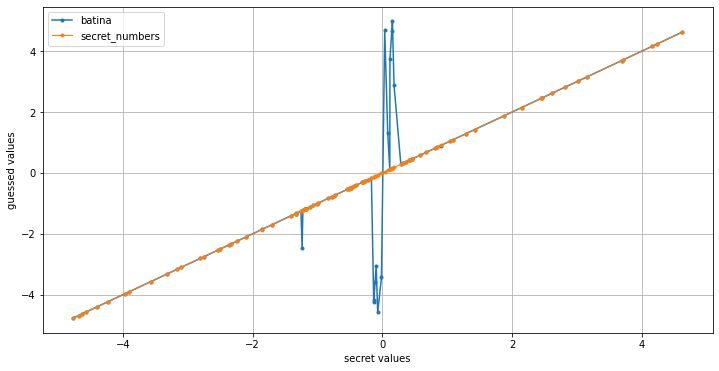

In [28]:
ax = batinta_results.plot(figsize = (12, 6), marker='.', label='batina')
#results.plot(ax=ax, marker='.', label='bxlab')
ax.plot(batinta_results.index, batinta_results.index, marker='.', linewidth=1, label='secret_numbers')
ax.legend()
ax.set_xlabel('secret values')
ax.set_ylabel('guessed values')
ax.grid(True)

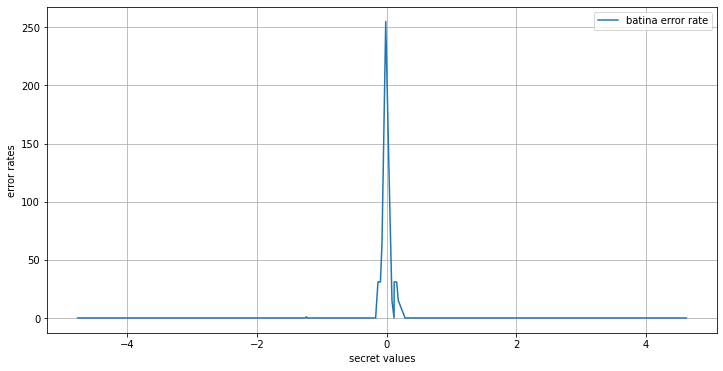

In [29]:
batina_error_rate = ((batinta_results - batinta_results.index)/batinta_results.index).abs()
ax = batina_error_rate.plot(figsize = (12, 6), label='batina error rate')
#ax = error_rate.plot(ax=ax, label='error rate')
ax.legend()
ax.set_xlabel('secret values')
ax.set_ylabel('error rates')
ax.grid(True)

In [30]:
batina_error_rate[batina_error_rate > 0.10]

-1.236503      0.999996
-0.132729     30.997450
-0.130656     31.000013
-0.111789     30.997681
-0.095132     30.997637
-0.071605     63.004179
-0.013398    255.006081
 0.036604    126.993134
 0.082832     14.996174
 0.116897     31.002445
 0.145472     30.999187
 0.155470     30.999644
 0.180273     14.997999
dtype: float64

In [51]:
####
# number of correctly guessed values / number of wrong values
###
(batina_error_rate < prescision).value_counts()

True     81
False    19
dtype: int64

# Annex

In [32]:
def annex_compute_corr(secret_hw, guess_range, known_inputs, guess_val_size=1000):
    low, high = guess_range
    guess_val = np.arange(low, high, (high - low) / (guess_val_size - 1e-5))
    hw = pd.DataFrame(columns=guess_val,
                        data=np.vectorize(hamming_weight)(known_inputs.reshape(-1, 1) * guess_val))
    return hw.corrwith(pd.Series(secret_hw), method='pearson')

In [33]:
guess_range=(-1e-0, 1e-0)
known_inputs = np.random.uniform(-1e9, 1e9, 500)
secret_number = -1.374e-4
secret_hw = np.vectorize(hamming_weight)(known_inputs * secret_number)
correlations = annex_compute_corr(secret_hw, guess_range, known_inputs, 1000)

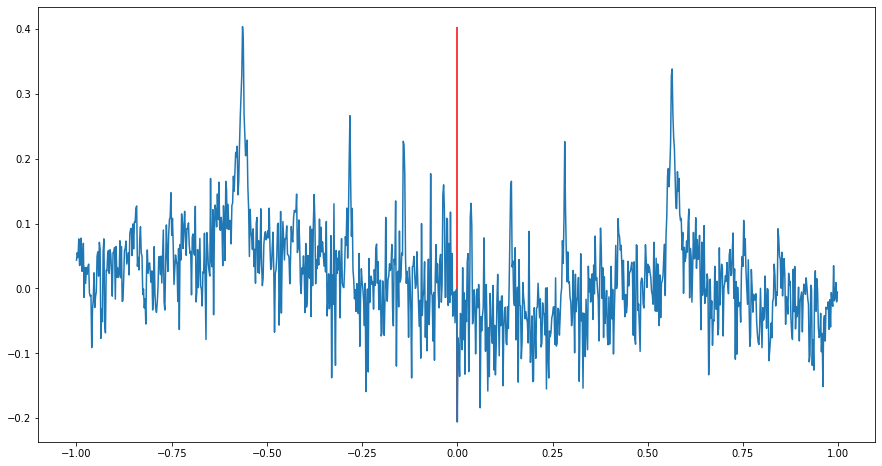

In [34]:
ax = correlations.plot(figsize=(15, 8))
ax.vlines(secret_number, correlations.min(), correlations.max(), color='red')

In [35]:
correlations.sort_values(ascending=False).iloc[:10]

-0.564    0.403603
-0.562    0.381387
 0.564    0.338465
-0.566    0.328667
 0.562    0.327039
-0.568    0.295336
 0.566    0.269498
-0.560    0.269187
-0.282    0.266391
-0.570    0.263976
dtype: float64

In [36]:
distance=1e-3
print('secret_number = %f' % secret_number)
correlations[(correlations.index > (secret_number-distance)) & (correlations.index < (secret_number+distance))]

secret_number = -0.000137


1.000000e-08   -0.205986
dtype: float64